<a href="https://colab.research.google.com/github/AkshayRai20/Projects1/blob/main/Akshay_Rai_Team_1_Capstone_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Facebook data project </u></b>

## <b> Problem Description </b>

### The leading treads towards social networking services had drawn massive
public attention from last one and half decade. The amount of data that is
uploaded to these social networking services is increasing day by day. So,
there is massive requirement to study the highly dynamic behavior of users
towards these services. This is a preliminary work to model the user
patterns and to study the effectiveness of machine learning predictive
modeling approaches on leading social networking service Facebook. We
modeled the user comment patters, over the posts on Facebook Pages and
predicted that how many comments a post is expected to receive in next H
hrs. In order to automate the process, we developed a software prototype
consisting of the crawler, Information extractor, information processor and
knowledge discovery module. We used Neural Networks and Decision Trees,
predictive modeling techniques on different dataset variants and evaluated
them under Hits(at)10 (custom measure), Area Under Curve, Evaluation Time
and Mean Absolute error evaluation metrics. We concluded that the Decision
trees performed better than the Neural Networks under light of all
evaluation metrics*.

### The amount of data that is uploaded to social networking services is
increasing day by day. So, their is massive requirement to study the highly
dynamic behavior of users towards these services. This work is to model the
user patterns and to study the effectiveness of machine learning predictive
modeling approaches on leading social networking service Facebook. We
modeled the user comment patters, over the posts on Facebook Pages and
predicted that how many comments a post is expected to receive in next H
hrs. To automate the process, we developed a software prototype consisting
of the crawler, Information extractor, information processor and knowledge
discovery module. We used Neural Networks and Decision Trees, predictive
modeling techniques on different data-set variants and evaluated them under
Hits(at)10, Area Under Curve, Evaluation Time and M.A.E metrics. We
concluded that the Decision trees performed better than the Neural Networks
under light of all metrics.

### Test.

#### * Test


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* 1
Page Popularity/likes
Decimal Encoding
Page feature
Defines the popularity or support for the source of the document.


2
Page Checkinsâ€™s
Decimal Encoding
Page feature
Describes how many individuals so far visited this place. This feature is only associated with the places eg:some institution, place, theater etc.


3
Page talking about
Decimal Encoding
Page feature
Defines the daily interest of individuals towards source of the document/ Post. The people who actually come back to the page, after liking the page. This include activities such as comments, likes to a post, shares, etc by visitors to the page.


4
Page Category
Value Encoding
Page feature
Defines the category of the source of the document eg: place, institution, brand etc.


5 - 29
Derived
Decimal Encoding
Derived feature
These features are aggregated by page, by calculating min, max, average, median and standard deviation of essential features.


30
CC1
Decimal Encoding
Essential feature
The total number of comments before selected base date/time.


31
CC2
Decimal Encoding
Essential feature
The number of comments in last 24 hours, relative to base date/time.


32
CC3
Decimal Encoding
Essential feature
The number of comments in last 48 to last 24 hours relative to base date/time.


33
CC4
Decimal Encoding
Essential feature
The number of comments in the first 24 hours after the publication of post but before base date/time.


34
CC5
Decimal Encoding
Essential feature
The difference between CC2 and CC3.


35
Base time
Decimal(0-71) Encoding
Other feature
Selected time in order to simulate the scenario.


36
Post length
Decimal Encoding
Other feature
Character count in the post.


37
Post Share Count
ï¿¼ï¿¼Decimal Encoding
Other feature
This features counts the no of shares of the post, that how many peoples had shared this post on to their timeline.


38
Post Promotion Status
ï¿¼ï¿¼Binary Encoding
Other feature
To reach more people with posts in News Feed, individual promote their post and this features tells that whether the post is promoted(1) or not(0).


39
H Local
ï¿¼Decimal(0-23) Encoding
Other feature
This describes the H hrs, for which we have the target variable/ comments received.


40-46
Post published weekday
Binary Encoding
Weekdays feature
This represents the day(Sunday...Saturday) on which the post was published.


47-53
Base DateTime weekday
Binary Encoding
Weekdays feature
This represents the day(Sunday...Saturday) on selected base Date/Time.

.



### Output:
* ### 54
Target Variable
Decimal
Target
The no of comments in next H hrs(H is given in Feature no 39)

In [102]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Testing on one file before merging all files
traindata = pd.read_csv('/content/drive/MyDrive/Cohort Aravali/CohortAravali-201005-153433.zip (Unzipped Files)/AlmaBetter/Module 4/Week 2/Day 2/dattr/Features_Variant_1.csv')

In [6]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))

In [7]:
trd=traindata

In [8]:
trd.head(3)

,634995,0,463,1,0.0,806.0,11.291044776119403,1.0,70.49513846124168,0.0.1,806.0.1,7.574626865671642,0.0.2,69.435826365571,0.0.3,76.0,2.6044776119402986,0.0.4,8.50550186882253,0.0.5,806.0.2,10.649253731343284,1.0.1,70.25478763764251,-69.0,806.0.3,4.970149253731344,0.0.6,69.85058043098057,0.1,0.2,0.3,0.4,0.5,65,166,2,0.6,24,0.7,0.8,0.9,1.1,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,1.2,0.19
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,10,132,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,14,133,2,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,7,0,3,7,-3,62,131,1,0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [9]:
trd.shape


(40948, 54)

In [10]:
trd.info

<bound method DataFrame.info of         634995   0     463  1  0.0   806.0  ...  0.15  0.16  0.17  0.18  1.2  0.19
0       634995   0     463  1  0.0   806.0  ...     0     0     0     1    0     0
1       634995   0     463  1  0.0   806.0  ...     0     0     0     0    1     0
2       634995   0     463  1  0.0   806.0  ...     0     0     0     0    0     0
3       634995   0     463  1  0.0   806.0  ...     0     1     0     0    0     0
4       634995   0     463  1  0.0   806.0  ...     0     0     0     1    0     0
...        ...  ..     ... ..  ...     ...  ...   ...   ...   ...   ...  ...   ...
40943  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0     1
40944  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0     2
40945  7170111  70  497000  9  0.0  1881.0  ...     0     0     1     0    0    72
40946  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0    28
40947  7170111  70  497000  9  0.0  1881.0  ...     0  

In [11]:
trd.describe

<bound method NDFrame.describe of         634995   0     463  1  0.0   806.0  ...  0.15  0.16  0.17  0.18  1.2  0.19
0       634995   0     463  1  0.0   806.0  ...     0     0     0     1    0     0
1       634995   0     463  1  0.0   806.0  ...     0     0     0     0    1     0
2       634995   0     463  1  0.0   806.0  ...     0     0     0     0    0     0
3       634995   0     463  1  0.0   806.0  ...     0     1     0     0    0     0
4       634995   0     463  1  0.0   806.0  ...     0     0     0     1    0     0
...        ...  ..     ... ..  ...     ...  ...   ...   ...   ...   ...  ...   ...
40943  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0     1
40944  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0     2
40945  7170111  70  497000  9  0.0  1881.0  ...     0     0     1     0    0    72
40946  7170111  70  497000  9  0.0  1881.0  ...     0     0     0     1    0    28
40947  7170111  70  497000  9  0.0  1881.0  ...     0

In [12]:
trd.columns =['likes', 'checkins', 'return', 'category', 'der1','der2','der3','der4','der5','der6','der7','der8','der9','der10','der11','der12','der13','der14','der15','der16','der17','der18','der19','der20','der21','der22','der23','der24','der25', 'comm0','comm24', 'comm4824', 'first24', 'diffcomm484224', 'simtime', 'length', 'sharecount',
 'prom_stat','hours','sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub',
       'sat_pub',  'sun_base', 'mon_base', 'tue_base', 'wed_base', 'thu_base',
       'fri_base', 'sat_base', 'target'] 

In [13]:
trd.head(3)

,likes,checkins,return,category,der1,der2,der3,der4,der5,der6,der7,der8,der9,der10,der11,der12,der13,der14,der15,der16,der17,der18,der19,der20,der21,der22,der23,der24,der25,comm0,comm24,comm4824,first24,diffcomm484224,simtime,length,sharecount,prom_stat,hours,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,target
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,10,132,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,14,133,2,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,7,0,3,7,-3,62,131,1,0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [14]:
trd.info

<bound method DataFrame.info of          likes  checkins  return  ...  fri_base  sat_base  target
0       634995         0     463  ...         1         0       0
1       634995         0     463  ...         0         1       0
2       634995         0     463  ...         0         0       0
3       634995         0     463  ...         0         0       0
4       634995         0     463  ...         1         0       0
...        ...       ...     ...  ...       ...       ...     ...
40943  7170111        70  497000  ...         1         0       1
40944  7170111        70  497000  ...         1         0       2
40945  7170111        70  497000  ...         0         0      72
40946  7170111        70  497000  ...         1         0      28
40947  7170111        70  497000  ...         1         0      11

[40948 rows x 54 columns]>

In [15]:
trd.describe

<bound method NDFrame.describe of          likes  checkins  return  ...  fri_base  sat_base  target
0       634995         0     463  ...         1         0       0
1       634995         0     463  ...         0         1       0
2       634995         0     463  ...         0         0       0
3       634995         0     463  ...         0         0       0
4       634995         0     463  ...         1         0       0
...        ...       ...     ...  ...       ...       ...     ...
40943  7170111        70  497000  ...         1         0       1
40944  7170111        70  497000  ...         1         0       2
40945  7170111        70  497000  ...         0         0      72
40946  7170111        70  497000  ...         1         0      28
40947  7170111        70  497000  ...         1         0      11

[40948 rows x 54 columns]>

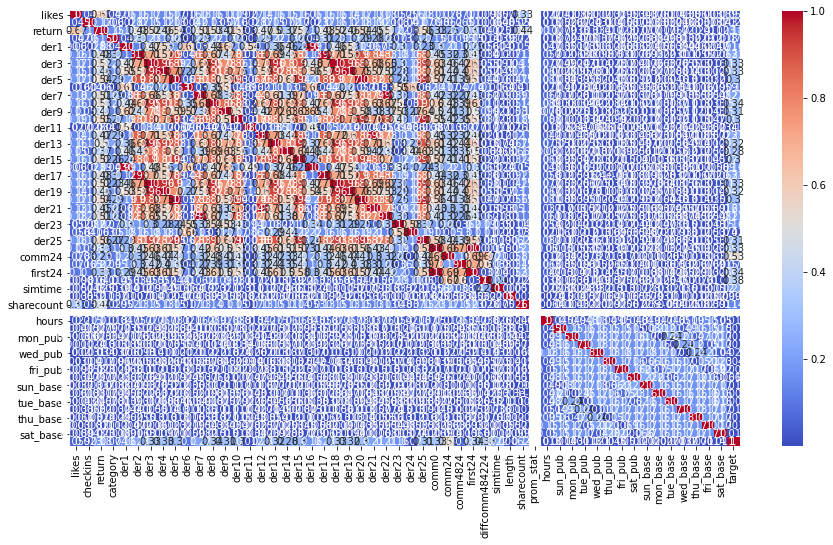

In [16]:
plt.figure(figsize=(15,8))
correlation=trd.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [17]:
#Too any features PCA needed

In [18]:
trd.isnull().sum()

likes             0
checkins          0
return            0
category          0
der1              0
der2              0
der3              0
der4              0
der5              0
der6              0
der7              0
der8              0
der9              0
der10             0
der11             0
der12             0
der13             0
der14             0
der15             0
der16             0
der17             0
der18             0
der19             0
der20             0
der21             0
der22             0
der23             0
der24             0
der25             0
comm0             0
comm24            0
comm4824          0
first24           0
diffcomm484224    0
simtime           0
length            0
sharecount        0
prom_stat         0
hours             0
sun_pub           0
mon_pub           0
tue_pub           0
wed_pub           0
thu_pub           0
fri_pub           0
sat_pub           0
sun_base          0
mon_base          0
tue_base          0
wed_base          0


In [51]:
#Removing derived and irrelevant features 
trd1=trd.drop(['diffcomm484224','prom_stat','der1','der2','der3','der4','der5','der6','der7','der8','der9','der10','der11','der12','der13','der14','der15','der16','der17','der18','der19','der20','der21','der22','der23','der24','der25'],axis='columns')

In [54]:
trd1.head(3)

,likes,checkins,return,category,comm0,comm24,comm4824,first24,simtime,length,sharecount,hours,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,target
0,634995,0,463,1,0,0,0,0,10,132,1,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,634995,0,463,1,0,0,0,0,14,133,2,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,634995,0,463,1,7,0,3,7,62,131,1,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


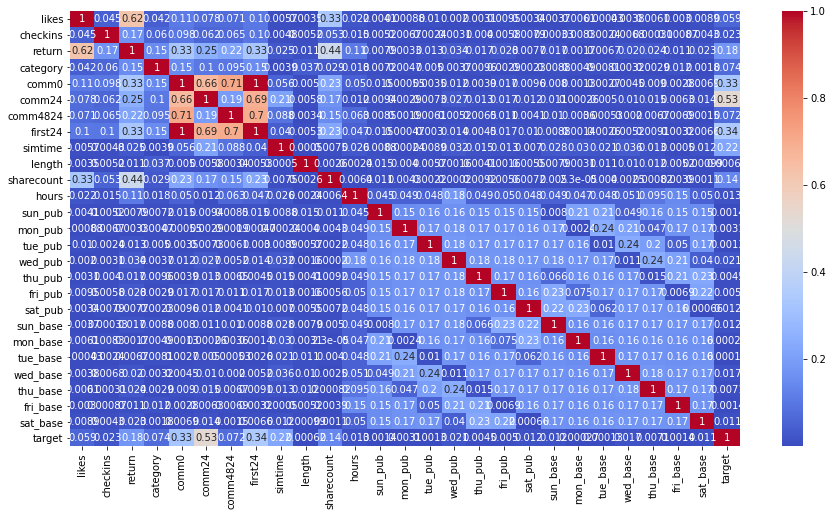

In [55]:
plt.figure(figsize=(15,8))
correlation=trd1.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [56]:
X = trd1.drop(['target'],axis=1)
y = trd1['target']


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

In [82]:
from sklearn import linear_model
from sklearn import datasets, linear_model, metrics 

In [64]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
pred = regr.predict(X_test)

In [66]:
test_r2 = r2_score(y_test, pred)
test_r2

0.34960988792614367

In [84]:
regr.score(X_test,y_test)

0.34960988792614367

In [43]:
trd1.head(3)

,likes,checkins,return,category,comm0,comm24,comm4824,first24,simtime,length,sharecount,prom_stat,hours,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,target
0,634995,0,463,1,0,0,0,0,10,132,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,634995,0,463,1,0,0,0,0,14,133,2,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,634995,0,463,1,7,0,3,7,62,131,1,0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [67]:
trd1.isnull().sum()

likes         0
checkins      0
return        0
category      0
comm0         0
comm24        0
comm4824      0
first24       0
simtime       0
length        0
sharecount    0
hours         0
sun_pub       0
mon_pub       0
tue_pub       0
wed_pub       0
thu_pub       0
fri_pub       0
sat_pub       0
sun_base      0
mon_base      0
tue_base      0
wed_base      0
thu_base      0
fri_base      0
sat_base      0
target        0
dtype: int64

In [69]:
trd1.value_counts()

likes    checkins  return  category  comm0  comm24  comm4824  first24  simtime  length  sharecount  hours  sun_pub  mon_pub  tue_pub  wed_pub  thu_pub  fri_pub  sat_pub  sun_base  mon_base  tue_base  wed_base  thu_base  fri_base  sat_base  target
2736     491       277     54        1      0       0         1        51       0       1           24     0        0        0        1        0        0        0        0         0         0         0         0         1         0         0         2
1670     0         8       13        0      0       0         0        38       0       1           24     0        0        0        0        0        1        0        1         0         0         0         0         0         0         0         2
5970921  53096     234501  9         20     20      0         20       12       309     44          24     1        0        0        0        0        0        0        0         1         0         0         0         0         0         12       

In [70]:
trd1['likes'].value_counts()



25879       246
595191      245
309914      244
3002026     244
965964      244
           ... 
2522433       1
201           1
11167         1
13504307      1
139           1
Name: likes, Length: 639, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f605c550>,
      dtype=object)

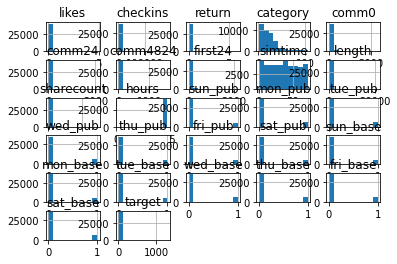

In [74]:
trd1.hist()

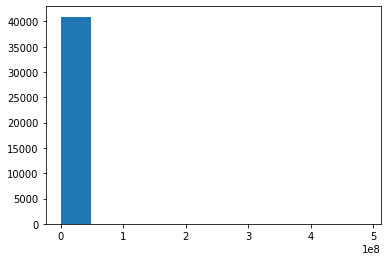

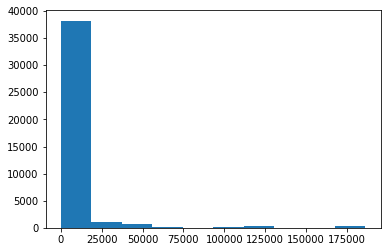

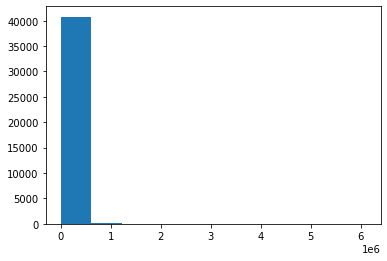

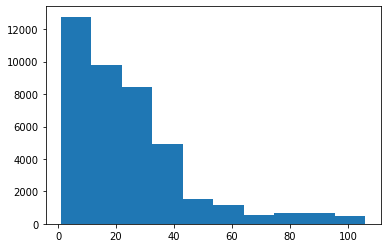

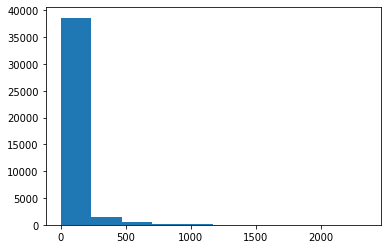

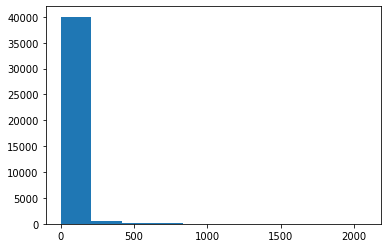

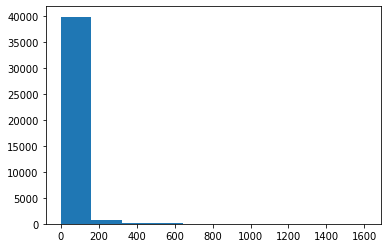

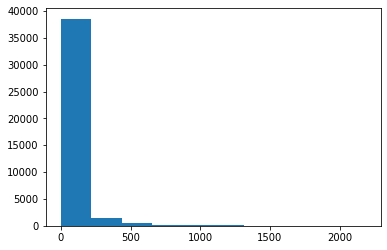

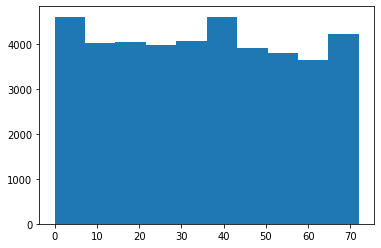

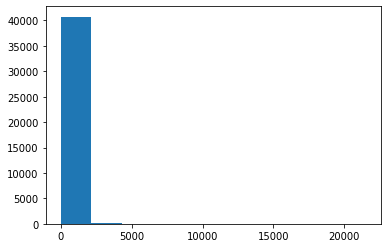

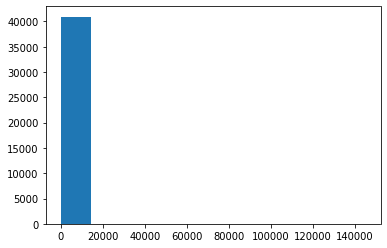

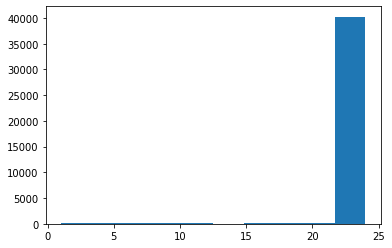

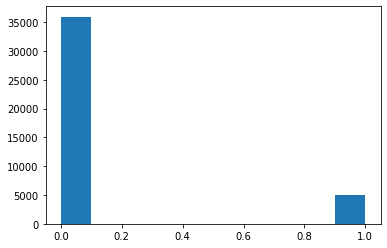

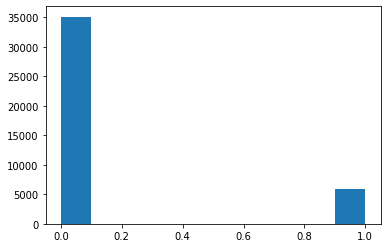

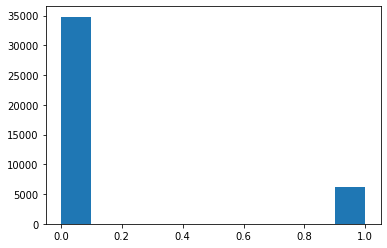

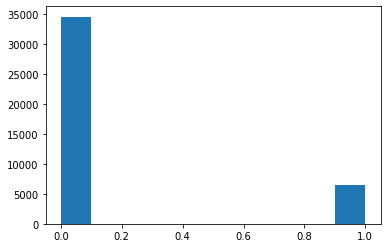

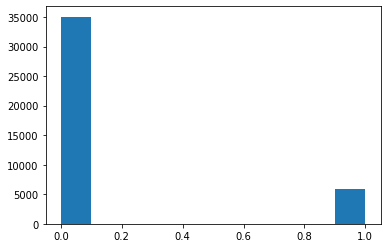

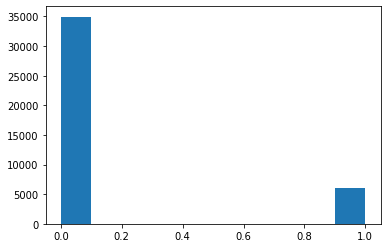

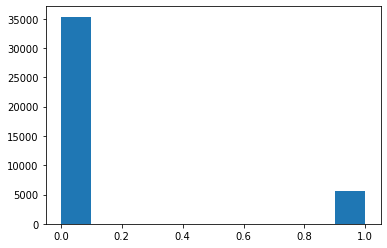

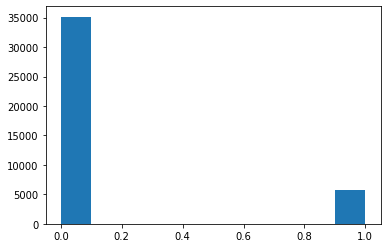

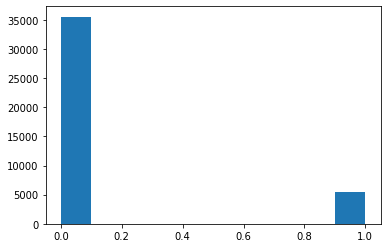

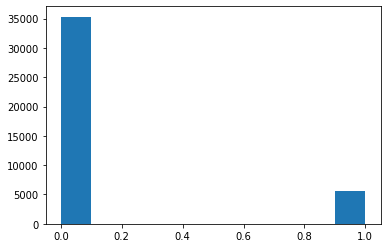

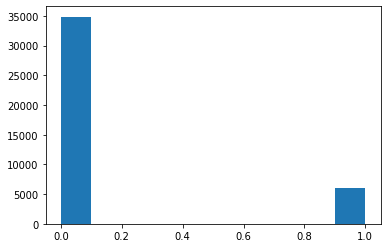

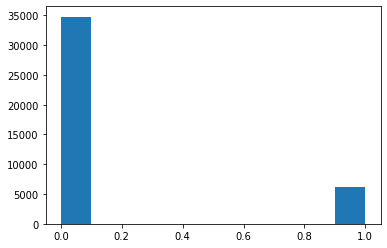

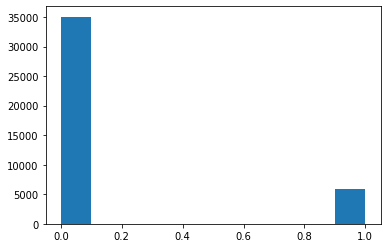

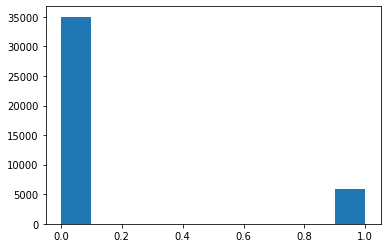

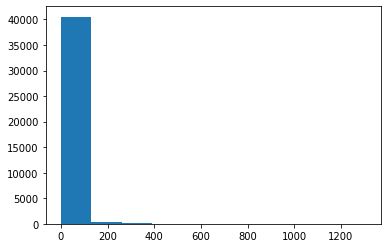

In [80]:
for i in trd1.columns:
    plt.figure()
    plt.hist(trd1[i])

In [90]:
#Running Random Forest
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [92]:
rfr.score(X_test,y_test)

0.67347348932982

In [94]:
#Decision tree
dt = tree.DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt.score(X_test,y_test)

0.3801923572617921

In [97]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [100]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression: 0.55


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      4510
           1       0.00      0.00      0.00      1036
           2       0.00      0.00      0.00       529
           3       0.00      0.00      0.00       312
           4       0.00      0.00      0.00       223
           5       0.00      0.00      0.00       184
           6       0.00      0.00      0.00       136
           7       0.00      0.00      0.00       117
           8       0.00      0.00      0.00        83
           9       0.00      0.00      0.00        76
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        59
          12       0.00      0.00      0.00        43
          13       0.00      0.00      0.00        42
          14       0.00      0.00      0.00        47
          15       0.00      0.00      0.00        54
          16       0.00      0.00      0.00        20
          17       0.00    